In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from cmath import isnan
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride + 1

def convtran2d_size_out(size, kernel_size, stride, output_padding=0):
    return (size - 1) * stride + (kernel_size - 1) + output_padding + 1

In [3]:
# obs -> featureにエンコード (SACでfeatureをstateとして用いる)
class Encoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32, lr=0.001):
        super().__init__()
        
        assert len(obs_shape) == 3 # obs_shape : CHW

        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = 3
        self.stride = 2

        self.convs = nn.ModuleList([nn.Conv2d(obs_shape[0], self.num_filters, self.kernel_size, stride=self.stride)])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, stride=self.stride))

        h = obs_shape[1]
        w = obs_shape[2]
        convh = conv2d_size_out(h, self.kernel_size, self.stride)
        convw = conv2d_size_out(w, self.kernel_size, self.stride)
        for i in range(num_layers - 1):
            convh = conv2d_size_out(convh, self.kernel_size, self.stride)
            convw = conv2d_size_out(convw, self.kernel_size, self.stride)
        self.linear_input_size = convw * convh * self.num_filters
        self.fc = nn.Linear(self.linear_input_size, self.feature_dim)
        self.ln = nn.LayerNorm(self.feature_dim)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, obs, detach=False):
        conv = F.relu(self.convs[0](obs))
        for i in range(1, self.num_layers):
            conv = F.relu(self.convs[i](conv))

        h = conv.view(conv.size(0), -1) # CHWを行ベクトルに変換
        if detach:
            h.detach()

        h = self.fc(h)
        feature = torch.tanh(self.ln(h))

        return feature

In [4]:
class Decoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32, latent_lambda=0.0, lr=0.001):
        super().__init__()

        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = 3
        self.stride = 2

        h = obs_shape[1]
        w = obs_shape[2]
        for i in range(num_layers - 1):
            h = conv2d_size_out(h, self.kernel_size, self.stride)
            w = conv2d_size_out(w, self.kernel_size, self.stride)
        self.convh = conv2d_size_out(h, self.kernel_size, self.stride)
        self.convw = conv2d_size_out(w, self.kernel_size, self.stride)

        linear_input_size = self.convw * self.convh * self.num_filters
        self.fc = nn.Linear(self.feature_dim, linear_input_size)

        self.deconvs = nn.ModuleList()

        for i in range(self.num_layers - 1):
            self.deconvs.append(nn.ConvTranspose2d(self.num_filters, self.num_filters, self.kernel_size, stride=self.stride))
        self.deconvs.append(nn.ConvTranspose2d(num_filters, obs_shape[0], self.kernel_size, stride=self.stride, output_padding=1))

        self.latent_lambda = latent_lambda
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=self.latent_lambda)
        
    def forward(self, h):
        h = F.relu(self.fc(h))
        deconv = h.view(-1, self.num_filters, self.convh, self.convw)
        for i in range(0, self.num_layers - 1):
            deconv = F.relu(self.deconvs[i](deconv))
        obs = torch.sigmoid(self.deconvs[-1](deconv)) # clipだと微分不可で進まない

        return obs

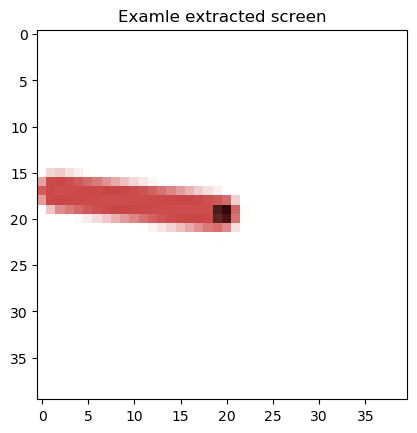

torch.Size([1, 3, 40, 40])


In [5]:
device = torch.device("cuda")

env = gym.make("Pendulum-v1", render_mode='rgb_array')

resize = T.Compose([T.ToPILImage(), T.Resize(40, T.InterpolationMode.BICUBIC), T.ToTensor()])

def get_screen():
    # PyTorch標準のCHWに変換
    screen = env.render().transpose(2, 0, 1)
    _, screen_height, screen_width = screen.shape

    # sliceでscreenをトリミング
    height_slice = slice(int(screen_height*0.25), int(screen_height * 0.75))
    screen = screen[:, height_slice]
    width_slice = slice(int(screen_width*0.25), int(screen_width * 0.75))
    screen = screen[:, :, width_slice]

    # float32に変換し0-1に正規化
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Tensorに変換
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


# Example
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Examle extracted screen')
plt.show()

print(get_screen().shape)


loss = 0.010301772


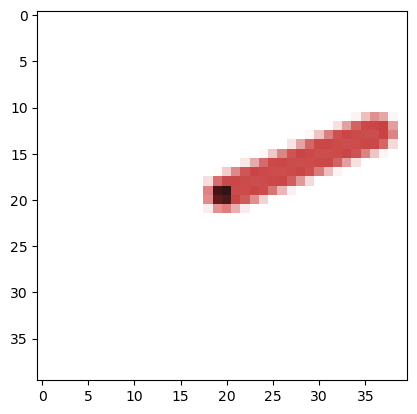

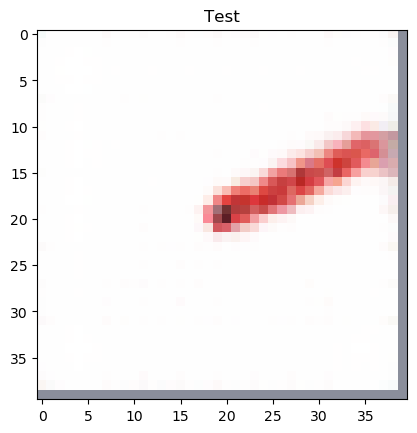

loss = 0.0057655


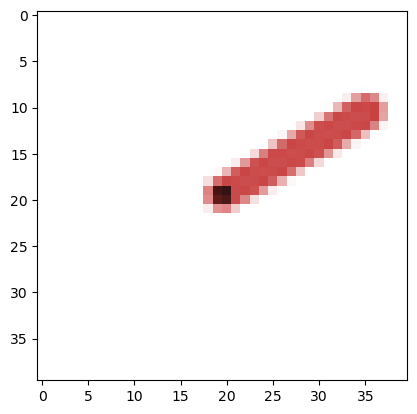

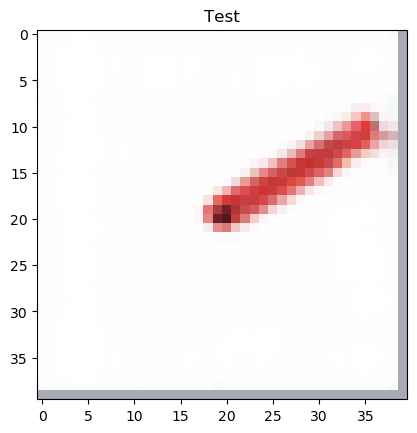

loss = 0.003069131


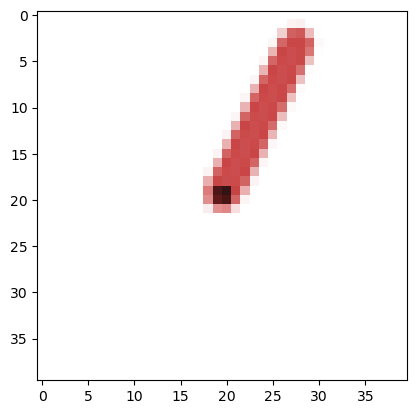

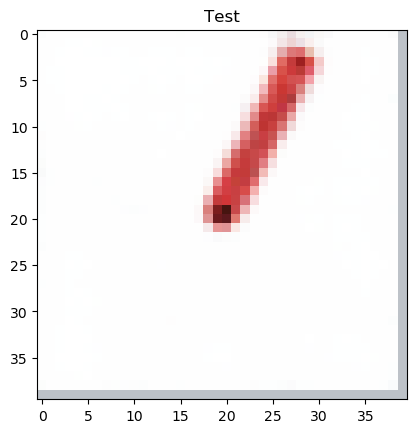

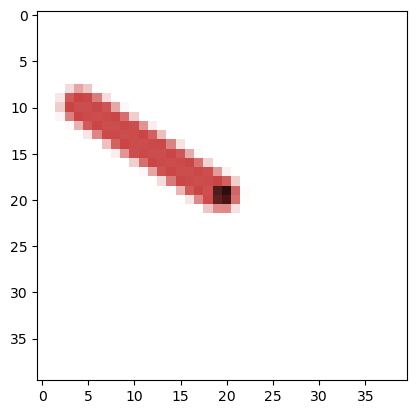

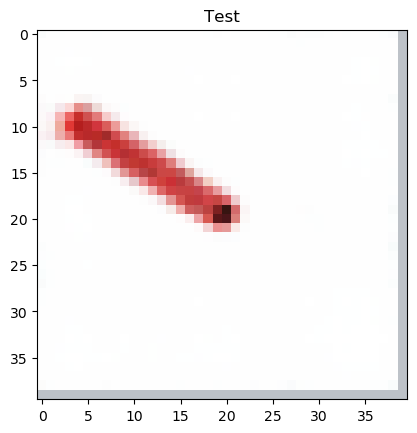

In [6]:
encoder = Encoder(get_screen()[0].shape, 30, 2, 32, 0.001).to(device)
decoder = Decoder(get_screen()[0].shape, 30, 2, 32, 0, 0.001).to(device)
count = 0

while count < 3000:
    env.reset()

    obs = get_screen()
    
    feature = encoder(obs)
    rec_obs = decoder(feature)

    loss = F.mse_loss(rec_obs, obs)

    encoder.optimizer.zero_grad()
    decoder.optimizer.zero_grad()

    loss.backward()

    encoder.optimizer.step()
    decoder.optimizer.step()

    count += 1

    if count % 1000 == 0:
        print("loss =", loss.cpu().detach().numpy())
        plt.figure()
        plt.imshow(obs.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
        plt.figure()
        plt.imshow(rec_obs.cpu().detach().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
        plt.title('Test')
        plt.show()

# テストで１枚表示
env.reset()

test_obs = get_screen()
test_rec_obs = decoder(encoder(test_obs))

plt.figure()
plt.imshow(test_obs.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.figure()
plt.imshow(test_rec_obs.cpu().detach().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Test')
plt.show()

torch.Size([1, 3, 40, 40])


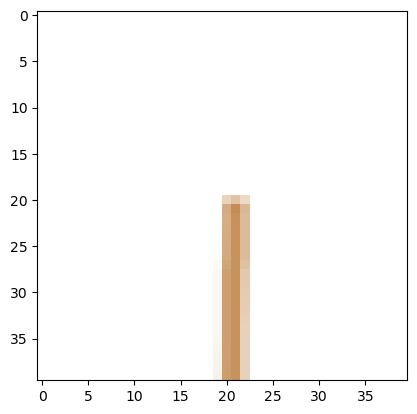

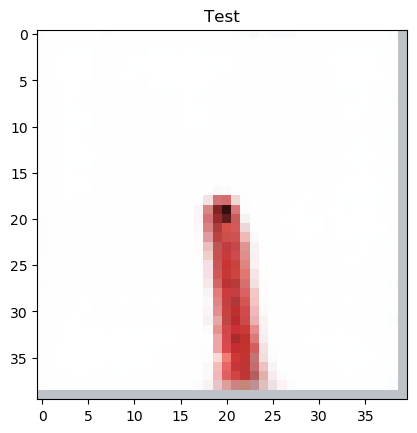

In [21]:
# 学習してない画像のリコンストラクションはできるのか
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()


def get_screen2():
    # PyTorch標準のCHWに変換
    screen = env.render().transpose(2, 0, 1)
    _, screen_height, screen_width = screen.shape

    # sliceでscreenをトリミング
    width_slice = slice(int(screen_width*0.35), int(screen_width * 0.65))
    screen = screen[:, :, width_slice]
    height_slice = slice(int(screen_height*0.2), int(screen_height * 0.65))
    screen = screen[:, height_slice]

    # float32に変換し0-1に正規化
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Tensorに変換
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

print(get_screen2().shape)
test_obs = get_screen2()
test_rec_obs = decoder(encoder(test_obs))

plt.figure()
plt.imshow(test_obs.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.figure()
plt.imshow(test_rec_obs.cpu().detach().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Test')
plt.show()